In [ ]:
import torch
import numpy as np
import cv2
import albumentations as A

from transformers import SamModel, SamProcessor
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionXLPipeline, StableDiffusionControlNetPipeline, StableDiffusionPipeline, StableDiffusionControlNetImg2ImgPipeline, StableDiffusionXLImg2ImgPipeline, StableDiffusionImg2ImgPipeline, DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline, StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image, make_image_grid
from PIL import Image, ImageFilter

stable_diffusion_2_inpainting = "stabilityai/stable-diffusion-2-inpainting"
stable_diffusion_refiner =  "stabilityai/stable-diffusion-xl-refiner-1.0"
stable_diffusion_2 = "stabilityai/stable-diffusion-2-1"
stable_diffusion_xl = "stabilityai/stable-diffusion-xl-base-1.0"
sam_model_name = "facebook/sam-vit-base"

cuda = "cuda"
cpu = "cpu"

In [ ]:
def read_image(filename):
    return Image.open("./Image-Gen/images/" + filename).convert("RGB")

In [ ]:
sam_processor = SamProcessor.from_pretrained(sam_model_name)
sam_model = SamModel.from_pretrained(sam_model_name)
sam_model = sam_model.to(cuda)

print("SAM loaded")

In [ ]:
stable_inpainting_pipe = StableDiffusionInpaintPipeline.from_pretrained(stable_diffusion_2, revision='fp16', torch_dtype=torch.float16).to(cpu)
# stable_inpainting_pipe = stable_inpainting_pipe

In [ ]:
stable_refiner_pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(stable_diffusion_refiner, variant="fp16", torch_dtype=torch.float16).to(cpu)
# stable_refiner_pipe = stable_refiner_pipe

In [ ]:
# stable_XL_pipe = StableDiffusionXLPipeline.from_pretrained(stable_diffusion_xl, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to(cuda)

In [ ]:
# stable_text_to_image_pipe = StableDiffusionPipeline.from_pretrained(model_id_t2i, torch_dtype=torch.float16)
# stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)

In [ ]:
# stable_img_2_img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_t2i, revision='fp16', torch_dtype=torch.float16)
# stable_img_2_img_pipe = stable_img_2_img_pipe.to(cpu)

In [ ]:
stable_XL_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

In [ ]:
# stable_text_to_image_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
stable_refiner_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

In [ ]:
prompt = "big ass, breasts, posing on the table, laying over, naked, nsfw,  ultrarealistic, soft lighting, 8k"
negative_prompt = "3d, cartoon, anime, (deformed eyes, nose, ears, nose), bad anatomy, ugly, more than 2 legs, more than 2 hands"

stable_XL_pipe = stable_XL_pipe.to(cuda)
output = stable_XL_pipe(prompt=prompt, negative_prompt=negative_prompt).images[0]
stable_XL_pipe = stable_XL_pipe.to(cpu)

stable_refiner_pipe = stable_refiner_pipe.to(cuda)
refined_image = stable_refiner_pipe(prompt=prompt, image=output, negative_prompt=negative_prompt).images[0]
stable_refiner_pipe = stable_refiner_pipe.to(cpu)

refined_image

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, use_safetensors=True)
# controlnet_pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
# )

controlnet_pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

controlnet_pipe.scheduler = UniPCMultistepScheduler.from_config(controlnet_pipe.scheduler.config)

controlnet = controlnet.to(cuda)
controlnet_pipe = controlnet_pipe.to(cuda)

In [8]:
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


def expand2square(pil_img, background_color=(255,255,255)):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [9]:
def to_image(img_array):
    return Image.fromarray(img_array)

In [10]:
def get_mask(image):
    global sam_model
    result = []
    input_points = [[[np.array(image.size)/2]]]

    input_data = sam_processor(image, input_points=input_points, return_tensors="pt")
    input_data = input_data.to(cuda)
    sam_model = sam_model.to(cuda)

    with torch.no_grad():
        prediction_output = sam_model(**input_data)
        
        prediction_output = sam_processor.image_processor.post_process_masks(
            prediction_output.pred_masks.cpu(), 
            input_data["original_sizes"].cpu(), 
            input_data["reshaped_input_sizes"].cpu()
        )
        
        if torch.cuda.is_available():
            # Empty the GPU cache and collect garbage
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

    masks = np.transpose(prediction_output[0][0, :, :, :].numpy(), [1, 2, 0]).astype(np.uint8) * 255
    sam_model = sam_model.to(cpu)
    return Image.fromarray(masks)

In [11]:
def find_contour(image):
    """
    Finds contours in the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        tuple: A tuple containing the contours and the thresholded image.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply binary thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    # Return the contours
    return contours, thresh

def get_centroid(contour):
    """
    Calculates the centroid of a contour.

    Args:
        contour (numpy.ndarray): The input contour.

    Returns:
        tuple: A tuple containing the centroid coordinates (x, y).
    """
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx = 0
        cy = 0
    return cx, cy

def add_padding(image):
    width, height = image.size
    size = max(width, height)
    new_width = size + 40
    new_height = size + 40
    padding = (20, 20, 20, 20)  # (left, top, right, bottom)
    padded_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))
    padded_image.paste(image, ((new_width - width) // 2, (new_height - height) // 2))
    return padded_image


transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.4, scale_limit=(-0.4, -0.4), rotate_limit=0, p=1, border_mode=1, interpolation=4,
                       shift_limit_y=[0.1, 0.25])
])

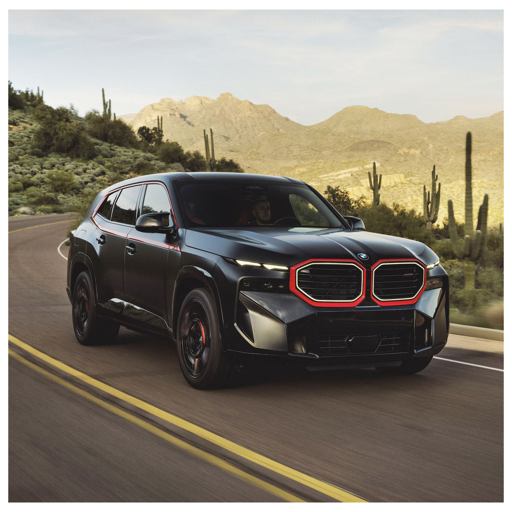

In [12]:
img_url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/p90499807-highres-the-bmw-xm-label-red-64beeff2ccfab.jpg?crop=0.670xw:1.00xh;0.136xw,0&resize=1200:*"


init_image = download_image(img_url)
# init_image = vedant
init_image = expand2square(init_image)
init_image = add_padding(init_image)
init_image = init_image.resize((512, 512))
init_image

In [13]:
import cv2
import numpy as np
from transformers import pipeline

In [ ]:
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
controlnet = controlnet.to(cuda)
controlnet_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

controlnet_pipe.scheduler = UniPCMultistepScheduler.from_config(controlnet_pipe.scheduler.config)
controlnet_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
controlnet_pipe = controlnet_pipe.to(cuda)

In [ ]:
# original_image = load_image(
#     "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
# )

# image = np.array(original_image)

image = np.array(init_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

In [ ]:
output = controlnet_pipe(
    "super saiyan", image=canny_image
).images[0]

In [ ]:
depth_estimator = pipeline("depth-estimation")

In [ ]:
def get_depth_map(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    depth_map = detected_map.permute(2, 0, 1)
    return depth_map

depth_map = get_depth_map(init_image, depth_estimator).unsqueeze(0).half().to("cuda")

In [ ]:
output = controlnet_pipe(prompt="realistic 8k octane rendered cinematic sasha grey with boobs", image=init_image, control_image=depth_map).images[0]

In [ ]:
make_image_grid([init_image, output], rows=1, cols=2)

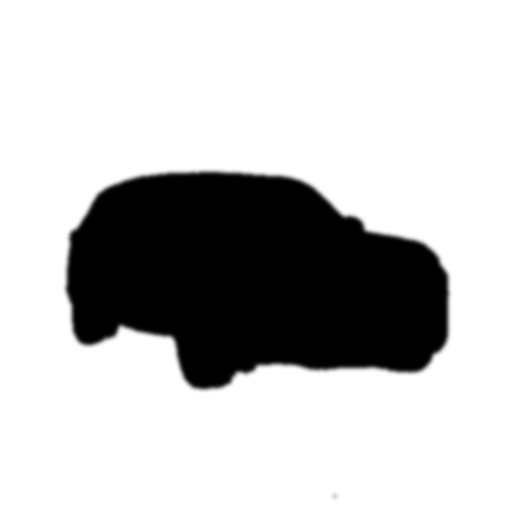

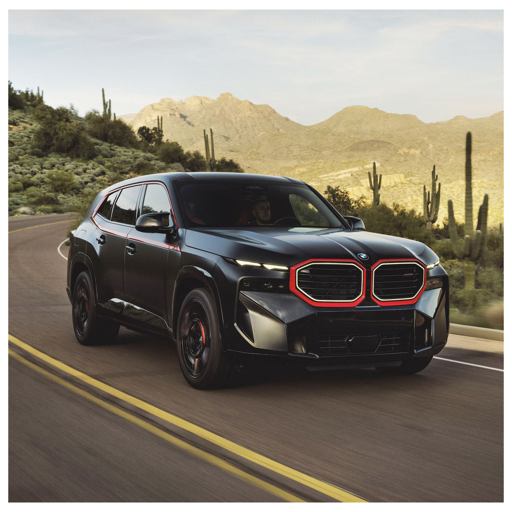

In [26]:

mask_image = get_mask(init_image)
# Convert the PIL.Image object to a numpy array
mask_array = np.array(mask_image)

# Find the indices where the colors are not white
non_black_indices = np.where(np.any(mask_array != 0, axis=-1))

# Set the non-white spots to white and everything else to black
mask_array_normalized = mask_array.copy()
mask_array_normalized[non_black_indices] = [255, 255, 255]
# mask_array[np.logical_not(non_white_indices)] = [0, 0, 0]

# Convert the numpy array back to a PIL.Image object
converted_mask_image = Image.fromarray(mask_array_normalized)
anti_mask = Image.fromarray(255 - np.array(converted_mask_image))#.filter(ImageFilter.GaussianBlur(8))

input_image = init_image
input_mask = anti_mask.filter(ImageFilter.GaussianBlur(2))

display(input_mask) 
display(input_image)

# DiffEdit

In [ ]:
diffedit_pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    model_id_t2i,
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)

diffedit_pipeline.scheduler = DDIMScheduler.from_config(diffedit_pipeline.scheduler.config)
diffedit_pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(diffedit_pipeline.scheduler.config)
# diffedit_pipeline.enable_model_cpu_offload()
# diffedit_pipeline.enable_vae_slicing()

diffedit_pipeline = diffedit_pipeline.to(cuda)

In [ ]:
source_prompt = "Picture of a car driving the desert"
target_prompt = "Car in the streets with a christmas theme background"
mask_image = diffedit_pipeline.generate_mask(
    image=init_image,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)
Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((512, 512))

In [ ]:
inv_latents = diffedit_pipeline.invert(prompt=source_prompt, image=init_image).latents

In [ ]:
output_image = diffedit_pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inv_latents,
    negative_prompt=source_prompt,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([init_image, mask_image, output_image], rows=1, cols=3)

# Everything else

In [ ]:
prompt_bg = "Streets with chrimas theme decoration, showing that it is chrismas time and there its beautiful and snowy"
with torch.no_grad():
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)
    image_bg = stable_text_to_image_pipe(prompt_bg, guidance_scale=10).images[0]
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cpu)
image_bg

In [ ]:
elements = [
    "chrismas theme",
    "make a road so that the car is pointing the correct direction",
    "realistic",
    "high res"]

negative_elements = [
    "longbody",
    "lowres",
    "bad anatomy",
    "bad hands",
    "missing fingers",
    "extra digit",
    "fewer digits",
    "cropped",
    "worst quality",
    'low quality',
    'letters',
    "miss-matched lighting",
    "miss-matched shadows",
    "changed reference image"
]


prompt = ", ".join(elements)
negative_prompt = ", ".join(negative_elements)


with torch.no_grad():
    print("prompt:", prompt)
    print("negative prompt:", negative_prompt)
    
    stable_img_2_img_pipe = stable_img_2_img_pipe.to(cuda)
    stable_refiner_pipe = stable_refiner_pipe.to(cuda)

    image = stable_img_2_img_pipe(prompt=prompt, negative_prompt=negative_prompt, image=init_image, strength=1, num_inference_steps=100, guidance_scale=10).images[0]

    refined_image = stable_refiner_pipe(
        prompt=prompt, 
        image=image, 
        num_inference_steps=50,
        strength=0.5,
        negative_prompt=negative_prompt,
        mask_image=input_mask).images[0]
    
    stable_img_2_img_pipe = stable_img_2_img_pipe.to(cpu)
    stable_refiner_pipe = stable_refiner_pipe.to(cpu)
    print("Done 👍")

refined_image

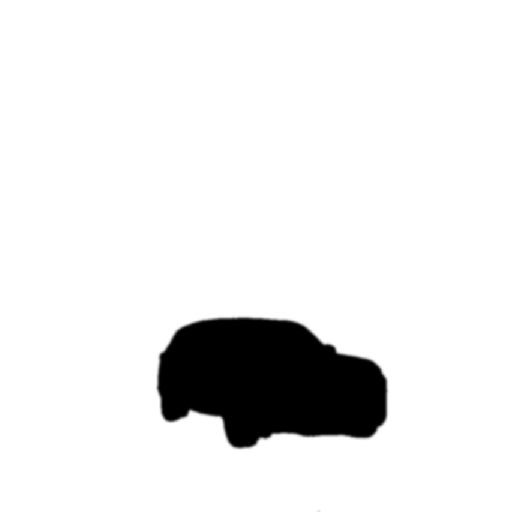

In [15]:
transformed_image_mask = transform(image=np.array(input_image), mask=np.array(input_mask))

input_image = to_image(transformed_image_mask['image'])
input_mask = to_image(transformed_image_mask['mask'])

# image_np = np.array(image_bg)
# idx = np.where(transformed_image_mask["mask"] == 0)
# image_np[idx[0], idx[1], :] = transformed_image_mask["image"][idx[0], idx[1], :]
input_mask

In [ ]:
# Find the contours and centroid of the mask
contours, ret = find_contour(transformed_image_mask["mask"])
cx, cy = get_centroid(contours[0])
max_min_cy = (contours[0][:, 0, 1].max() - contours[0][:, 0, 1].min()) // 3

In [ ]:
anchor_point = int(np.random.uniform(0, max_min_cy))
anti_mask = np.copy(transformed_image_mask["mask"])
anti_mask[(cy - anchor_point):, :, :] = 0
anti_mask_lower = 255 - (transformed_image_mask["mask"] - anti_mask)

In [ ]:
anti_mask = np.copy(transformed_image_mask["mask"])
anti_mask[:(cy - anchor_point), :] = 0
anti_mask_upper = 255 - (transformed_image_mask["mask"] - anti_mask)
anti_mask_upper = Image.fromarray(255 - anti_mask_upper).filter(ImageFilter.GaussianBlur(4))
new_mask_ori = Image.fromarray(transformed_image_mask["mask"])
new_mask = new_mask_ori.filter(ImageFilter.GaussianBlur(8))

anti_mask_upper

In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [31]:
elements = [
    "car on downtown city roads",
    "night",
    "christmas theme background",
    "christmas lights",
    "good shadows",
    "good lighting",
    "realistic",
    "high res",
    "8k",
    "cinematic"]

negative_elements = [
    "bad quality",
    "cartoony",
    "longbody",
    "lowres",
    "bad anatomy",
    "bad hands",
    "missing fingers",
    "extra digit",
    "fewer digits",
    "cropped",
    "worst quality",
    'low quality',
    'letters',
    "miss-matched lighting",
    "miss-matched shadows",
    "altered the original subject"
]

# "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters" 

prompt = ", ".join(elements)
negative_prompt = ", ".join(negative_elements)

with torch.no_grad():
    print("prompt:", prompt)
    print("negative prompt:", negative_prompt)

    stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
    stable_refiner_pipe = stable_refiner_pipe.to(cuda)

    image = stable_inpainting_pipe(
        prompt=prompt, 
        image=input_image, 
        mask_image=input_mask, 
        num_inference_steps=100,
        negative_prompt=negative_prompt,
        guidance_scale=7,
        strength=0.7).images[0]
    
    
    refined_image = stable_refiner_pipe(
        prompt=prompt, 
        image=image, 
        num_inference_steps=50,
        strength=0.3,
        negative_prompt=negative_prompt).images[0]
    
    stable_inpainting_pipe = stable_inpainting_pipe.to(cpu)
    stable_refiner_pipe = stable_refiner_pipe.to(cpu)

    print("Done 👍")

prompt: car on downtown city roads, night, christmas theme background, christmas lights, good shadows, good lighting, realistic, high res, 8k, cinematic
negative prompt: longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters, miss-matched lighting, miss-matched shadows, alter the original subject


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Done 👍


In [33]:
logo = download_image("https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/BMW.svg/2048px-BMW.svg.png")

In [37]:
from PIL import Image
def remove_white_border(image):
    # Convert the image to grayscale
    gray_image = image.convert("L")
    
    # Get the dimensions of the image
    width, height = gray_image.size
    
    # Define the border color
    border_color = 255  # White
    
    # Check if the top border is white
    top_border = True
    for x in range(width):
        if gray_image.getpixel((x, 0)) != border_color:
            top_border = False
            break
    
    # Check if the bottom border is white
    bottom_border = True
    for x in range(width):
        if gray_image.getpixel((x, height - 1)) != border_color:
            bottom_border = False
            break
    
    # Check if the left border is white
    left_border = True
    for y in range(height):
        if gray_image.getpixel((0, y)) != border_color:
            left_border = False
            break
    
    # Check if the right border is white
    right_border = True
    for y in range(height):
        if gray_image.getpixel((width - 1, y)) != border_color:
            right_border = False
            break
    
    # Calculate the new dimensions of the image
    new_width = width
    new_height = height
    if top_border:
        new_height -= 20
    if bottom_border:
        new_height -= 20
    if left_border:
        new_width -= 20
    if right_border:
        new_width -= 20
    
    # Crop the image to remove the white border
    cropped_image = image.crop((20, 20, new_width, new_height))
    
    return cropped_image


def insert_logo(image, logo_path, position='left', logo_size=(50, 50)):
    # Open the logo image
    logo = Image.open(logo_path)
    
    # Resize the logo image
    logo = logo.resize(logo_size)
    
    # Convert the image to RGBA mode
    image = image.convert("RGBA")
    
    # Calculate the position to insert the logo
    if position == 'left':
        x = 0
        y = 0
    elif position == 'right':
        x = image.width - logo.width
        y = 0
    else:
        raise ValueError("Invalid position. Position must be 'left' or 'right'.")
    
    # Paste the logo onto the image
    image.paste(logo, (x, y), mask=logo)
    
    return image


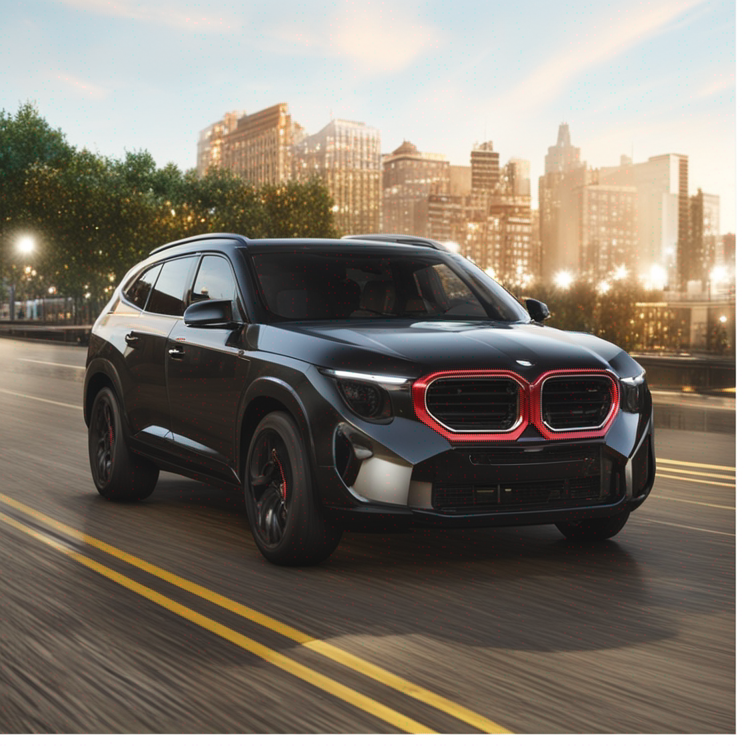

In [39]:
remove_white_border(refined_image)

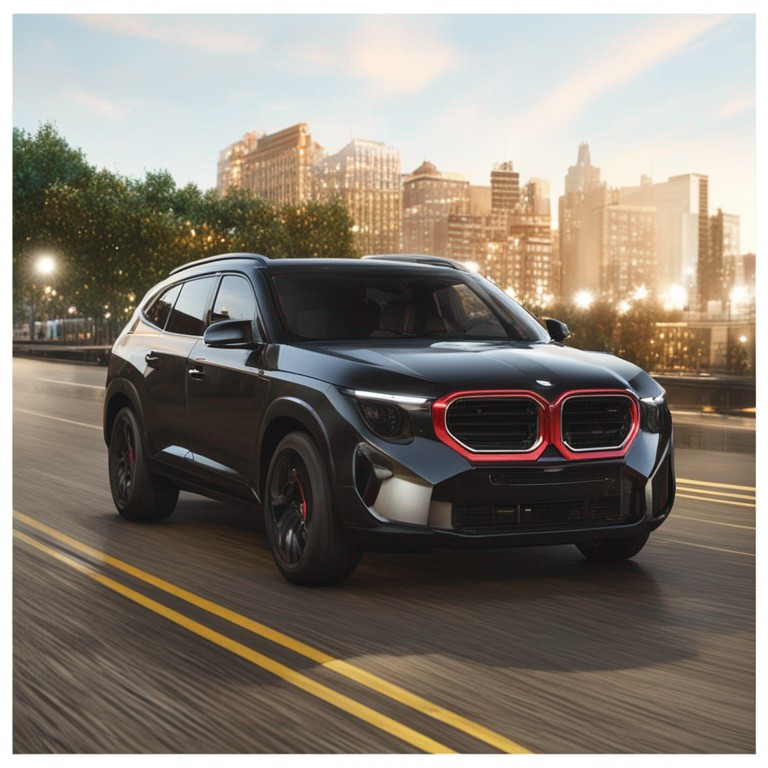

In [35]:
refined_image

# Control Net

In [ ]:
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = 1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

In [ ]:
mask_image = to_image(mask_array_normalized)

In [ ]:
input_mask = anti_mask
control_image = make_inpaint_condition(init_image, input_mask)

In [ ]:
elements = [
    "car on streets",
    "christmas theme decorations",
    "match the shadows",
    "match the lighting",
    "realistic",
    "high res"]

negative_elements = [
    "longbody",
    "lowres",
    "bad anatomy",
    "bad hands",
    "missing fingers",
    "extra digit",
    "fewer digits",
    "cropped",
    "worst quality",
    'low quality',
    'letters',
    "miss-matched lighting",
    "miss-matched shadows",
    "alter the original subject"
]

# "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters" 

prompt = ", ".join(elements)
negative_prompt = ", ".join(negative_elements)

output = controlnet_pipe(
    prompt="hilly roads",
    # negative_prompt=negative_prompt,
    num_inference_steps=100,
    strength=0.8,
    # eta=1.0,
    image=init_image,
    mask_image=input_mask,
    control_image=control_image,
).images[0]

In [ ]:
output